信用情報の学習

【問題1】コンペティション内容の確認

＜何を学習し、何を予測するのか＞

学習する内容は、顧客の性別や、資産などの様々な情報
目的変数は１と０のラベルデータで返済が困難な人か、そうでないか

＜どのようなファイルを作りKaggleに提出するか＞

テストセットの中のTARGET variableを予測する。
その際に、「SUbmission File」のページ記載のヘッダーとフォーマットで提出

＜提出されたものはどういった指標値で評価されるのか＞

予測値と観測された目的変数間での、ROC曲線の下の面積(AUC)で評価される

【問題2】学習と検証

データを簡単に分析、前処理し、学習、検証するまでの一連の流れを作成・実行。検証にはこのコンペティションで使用される評価指標を用いるようにしてください。学習に用いる手法は指定しません。

In [18]:
# 取り込みをしap_dataとする

import pandas as pd
import numpy as np

ap_data=pd.read_csv("/Users/chidayasuhiro/diveintocode-ml/application_train.csv")

In [19]:
# testも取り込んでおき、ap_data_testとする

ap_data_test=pd.read_csv("/Users/chidayasuhiro/diveintocode-ml/application_test.csv")

In [20]:
ap_data["AMT_INCOME_TOTAL"].isnull().sum()

0

In [21]:
ap_data["AMT_GOODS_PRICE"].isnull().sum()

278

In [22]:
# 説明変数としてAMT_INCOME_TOTALとAMT_GOODS_PRICEで学習を行う
# AMT_GOODS_PRICEには278の欠損値があるのでそのIDは削除を行う

ap_data1=ap_data[["AMT_INCOME_TOTAL","AMT_GOODS_PRICE","TARGET"]]

In [23]:
#　欠損値のある行を削除

ap_data2=ap_data1.dropna(how="any")

In [25]:
#訓練データと検証データの分割

# pandasからnparrayへ
import numpy as np
ap_data2_np=np.array(ap_data2)

# 分割
from sklearn.model_selection import train_test_split
ap_data2_npsp=train_test_split(ap_data2_np)

a_train,a_test=ap_data2_npsp

In [26]:
# ＜ロジスティック回帰＞を行う
a_train_x=a_train[:,0:2]
a_train_y=a_train[:,2]
a_test_x=a_test[:,0:2]
a_test_y=a_test[:,2]

#　学習
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
clf.fit(a_train_x,a_train_y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [27]:
# 推定
clf.predict(a_test_x)

array([0., 0., 0., ..., 0., 0., 0.])

In [37]:
#　評価　ROC曲線の下の面積(AUC)で評価

y_pred_clf=clf.predict(a_test_x)
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

chi=list(a_test_y)
da=list(y_pred_clf)

roc = roc_curve(chi,da)

In [29]:
fpr, tpr, thresholds = roc_curve(chi,da)

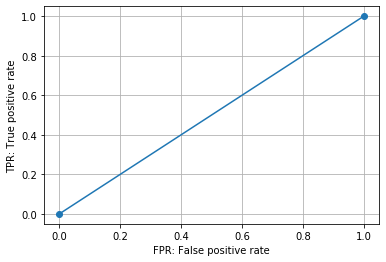

In [30]:
plt.plot(fpr, tpr, marker='o')
plt.xlabel('FPR: False positive rate')
plt.ylabel('TPR: True positive rate')
plt.grid()

＜評価について＞

ROC曲線が対角線となってしまった
これは不十分なモデルであると言える

【問題3】テストデータに対する推定

In [31]:
# テストデータの説明変数（特徴量）である、AMT_INCOME_TOTALとAMT_GOODS_PRICEを抜き出す

ap_data_test_x=ap_data_test[["AMT_INCOME_TOTAL","AMT_GOODS_PRICE"]]

In [32]:
# 推定
ap_data_test_xnp=np.array(ap_data_test_x)

clf.predict(ap_data_test_xnp)

array([0., 0., 0., ..., 0., 0., 0.])

In [33]:
y_pred_test=clf.predict(ap_data_test_xnp)
y_pred_test=pd.DataFrame(y_pred_test,columns=["target"])
test1=pd.concat([ap_data_test["SK_ID_CURR"],y_pred_test],axis=1)

In [ ]:
# これをcsvに書き出してKaggleに提出を行う
# 無事に提出完了

# test1.to_csv("submission.csv",index=False)

【問題4】特徴量エンジニアリング

精度を上げるために以下のような観点で 特徴量エンジニアリング（Feature Engineering） を行ってください。

・どの特徴量を使うか

・どう前処理をするか

In [34]:
#　特徴量エンジニアリング１　問題２と問題３で行ったものを標準化しロジスティックを行う

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(a_train_x)
a_train_xstd=scaler.transform(a_train_x)
a_test_xstd=scaler.transform(a_test_x)

In [35]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
clf.fit(a_train_xstd,a_train_y)
# 推定
y_pred_clf_std=clf.predict(a_test_xstd)

In [38]:
# ROC曲線と下の面積(AUC)で評価を行う
# 結果は悪い物になった
chi=list(a_test_y)
da=list(y_pred_clf_std)

roc_auc_score(chi, da)

0.5

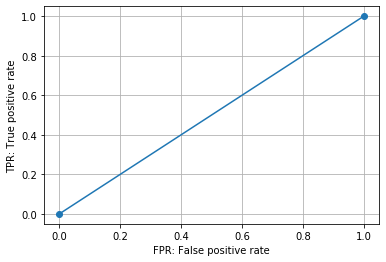

In [39]:
roc = roc_curve(chi,da)
plt.plot(fpr, tpr, marker='o')
plt.xlabel('FPR: False positive rate')
plt.ylabel('TPR: True positive rate')
plt.grid()

In [40]:
#　特徴量エンジニアリング２　決定木の手法で分析を行う

from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

clftree = DecisionTreeClassifier(random_state=0)
clftree.fit(a_train_xstd,a_train_y)

y_pred_clftree=clftree.predict(a_test_xstd)

In [41]:
# ROC曲線と下の面積(AUC)で評価を行う
# ロジスティック回帰よりほんの少しよくなった可能性はあるが、決定木でもあまり良い分析とは言えなかった
chi=list(a_test_y)
da=list(y_pred_clftree)

roc_auc_score(chi, da)

0.5000359280966413

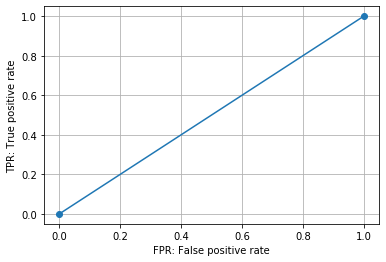

In [42]:
roc = roc_curve(chi,da)
plt.plot(fpr, tpr, marker='o')
plt.xlabel('FPR: False positive rate')
plt.ylabel('TPR: True positive rate')
plt.grid()

In [43]:
#　特徴量エンジニアリング３　特徴量の変更 TOTAL_INCOMEをEXT_SOURCE_2に変更し分析を行ってみる
#　手法は決定木で行う

ap_data_es2=ap_data["EXT_SOURCE_2"]
ap_data_es2

ap_data_3=ap_data[["EXT_SOURCE_2","AMT_GOODS_PRICE","TARGET"]]

In [44]:
# 欠損値のある行は削除

ap_data_3no1=ap_data_3.dropna(how="any")

In [45]:
# 分割して標準化を行う

# pandasからnparrayへ
import numpy as np
ap_data_3no1=np.array(ap_data_3no1)

# 分割
from sklearn.model_selection import train_test_split
ap_data_3no1_sp=train_test_split(ap_data_3no1)

a_train_x,a_test_x=ap_data_3no1_sp
a_train_x2=a_train_x[:,0:2]
a_train_y2=a_train_x[:,2]
a_test_x2=a_test_x[:,0:2]
a_test_y2=a_test_x[:,2]


#　標準化
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(a_train_x2)
a_train_xstd=scaler.transform(a_train_x2)
a_test_xstd=scaler.transform(a_test_x2)

In [46]:
#　学習
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

clftree = DecisionTreeClassifier(random_state=0)
clftree.fit(a_train_xstd,a_train_y2)

y_pred_clftree=clftree.predict(a_test_xstd)

In [47]:
# ROC曲線と下の面積(AUC)で評価を行う

chi=list(a_test_y2)
da=list(y_pred_clftree)

roc_auc_score(chi, da)

0.5174187551324425

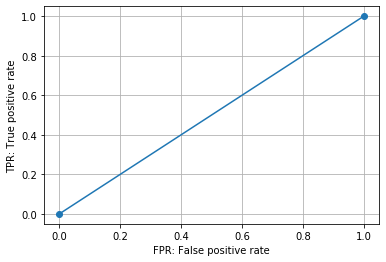

In [48]:
roc = roc_curve(chi,da)
plt.plot(fpr, tpr, marker='o')
plt.xlabel('FPR: False positive rate')
plt.ylabel('TPR: True positive rate')
plt.grid()

In [49]:
#　特徴量エンジニアリング４　特徴量はエンジニアリング３のもので、手法を決定木からロジスティック回帰を行って精度の検証を行う

# 学習
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
clf.fit(a_train_xstd,a_train_y2)

y_pred_clf=clf.predict(a_test_xstd)

In [50]:
# ROC曲線と下の面積(AUC)で評価を行う
chi=list(a_test_y2)
da=list(y_pred_clf)

roc_auc_score(chi, da)

0.5

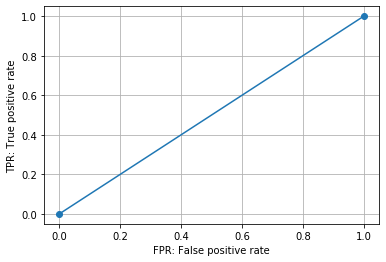

In [51]:
roc = roc_curve(chi,da)
plt.plot(fpr, tpr, marker='o')
plt.xlabel('FPR: False positive rate')
plt.ylabel('TPR: True positive rate')
plt.grid()

In [52]:
#　特徴量エンジニアリング５　特徴量をAMT_INCOME_TOTALとAMT_GOODS_PRICEとEXT_SOURCE_2の３つで行う、手法は決定木で行う

ap_data5=ap_data[["AMT_INCOME_TOTAL","AMT_GOODS_PRICE","EXT_SOURCE_2","TARGET"]]
ap_data6=ap_data5.dropna(how="any")

In [53]:
# pandasからnparrayへ
import numpy as np
ap_data6=np.array(ap_data6)

# 分割
from sklearn.model_selection import train_test_split
ap_data6_sp=train_test_split(ap_data6)

a_train_x,a_test_x=ap_data6_sp
a_train_x2=a_train_x[:,0:3]
a_train_y2=a_train_x[:,3]
a_test_x2=a_test_x[:,0:3]
a_test_y2=a_test_x[:,3]

In [75]:
#標準化
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(a_train_x2)
a_train_xstd=scaler.transform(a_train_x2)
a_test_xstd=scaler.transform(a_test_x2)

In [78]:
#　学習
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

clftree = DecisionTreeClassifier(random_state=0)
clftree.fit(a_train_xstd,a_train_y2)
y_pred_clftree=clftree.predict(a_test_xstd)

In [59]:
# ROC曲線と下の面積(AUC)で評価を行う

chi=list(a_test_y2)
da=list(y_pred_clftree)

roc_auc_score(chi, da)

0.5212214882523694

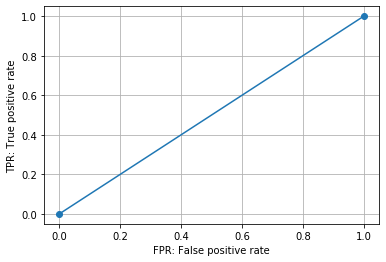

In [60]:
roc = roc_curve(chi,da)
plt.plot(fpr, tpr, marker='o')
plt.xlabel('FPR: False positive rate')
plt.ylabel('TPR: True positive rate')
plt.grid()

In [85]:
# 特徴量エンジニアリング５が最も精度が良かったためテストに対して推定を行う
# テストデータの説明変数（特徴量）である、AMT_INCOME_TOTALとAMT_GOODS_PRICEとEXT_SOURCE_2を抜き出す

ap_data_test_x2=ap_data_test[["AMT_INCOME_TOTAL","AMT_GOODS_PRICE","EXT_SOURCE_2"]]

ap_data_test_x3=ap_data_test_x2.dropna(how="any")
ap_data_test_xnp3=np.array(ap_data_test_x3)

In [86]:
# テストデータに対して推定を行う
#　標準化

ap_data_test_xnp2std=scaler.transform(ap_data_test_xnp3)

In [87]:
y_pred_clftree=clftree.predict(ap_data_test_xnp2std)

In [89]:
y_pred_test2=pd.DataFrame(y_pred_test,columns=["target"])
test2=pd.concat([ap_data_test["SK_ID_CURR"],y_pred_test],axis=1)

In [90]:
# これをcsvに書き出してKaggleに提出を行う
# 無事に提出完了

#test2.to_csv("submission2.csv",index=False)